In [1]:
from train import *
from model import *
from helpers import *
from include import *

import os
import time
import plac
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from IPython.display import clear_output

import numpy as np
from PIL import Image

import torch
from torch import nn, Tensor
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.datasets as dset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    dtype = torch.FloatTensor

num GPUs 2


In [2]:
# low shots
num_of_low_shots = 10
num_of_val = 24
image_size = 128

# Root directory for dataset
data_root = "./CelebA_data/celeba"

batch_size = 1
data_set = dset.ImageFolder(root=data_root,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor() ]))

train_set = torch.utils.data.Subset(data_set, range(len(data_set)-num_of_low_shots, len(data_set), 1))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# validate images
val_set = torch.utils.data.Subset(data_set, range(24, 44, 1))
val_loader = torch.utils.data.DataLoader(val_set, shuffle=False, batch_size=1)

In [3]:
# low shots in the current training batch
# Xi_train, _= (next(iter(train_loader)))

# for i, (Xi_train, _) in enumerate(train_loader):
#     plt.figure(figsize=(3, 3))
#     for i in range(len(Xi_train)):
#         plt.subplot(1, len(Xi_train), i + 1)
#         imgshow(Xi_train[i])
#         plt.axis('off');

In [4]:
# one validate image
val_image, _ = val_set[1]
img_clean_var = val_image.view(-1, 3, 128, 128).to(device)

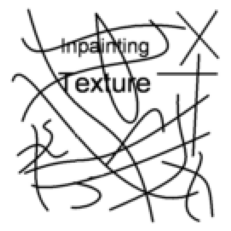

In [5]:
# given mask
output_depth = 3
img_mask_pil = Image.open('./mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)
plt.imshow(var_to_np(mask_var).transpose(1, 2, 0))
plt.axis('off');

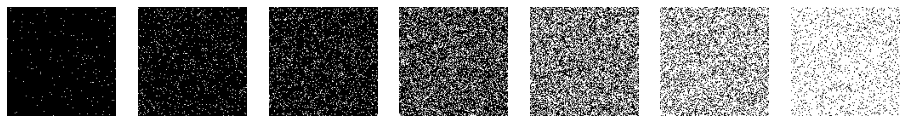

In [6]:
# random masks
ratios = np.array([0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9])
masks = torch.zeros(len(ratios), 3, image_size, image_size).to(device)

plt.figure(figsize=(16, 8))
for i in range(len(masks)):
    plt.subplot(1, len(masks), i + 1)
    tmp = torch.cuda.FloatTensor(1, 1, image_size, image_size).uniform_() < ratios[i]
    tmp = tmp.view(-1, 1, 128, 128)
    
    mask_np = var_to_np(tmp)
    mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * 3)
    masks[i] = np_to_var(mask_np).type(dtype)

    plt.imshow(mask_np.transpose(1, 2, 0))
    plt.axis('off');

In [7]:
code_dim = 128
epoch_for_train_z = 2000
psnr_list = np.zeros(len(val_set))
num_channels = [64]*3
rnd = 500
numit = 8000
rn = 0.005

final_output = torch.zeros((num_of_val, 3, 128, 128)).to(device)
def train_all_val(mask_var):
    psnr_list = np.zeros(num_of_val)
    mask_var = mask_var.to(device)

    for i, (img_clean_var, _) in enumerate(val_loader):
        progress = tqdm(total=1, desc='loop % 3d' % i)
        
        # for image i
        img_clean_var = Variable(img_clean_var).to(device)
        img_noisy_var = (img_clean_var * mask_var).to(device)
        
        # load pre-trained decoder
        train_decoder = deconv_decoder(num_channels_up=num_channels, upsample_mode='none', filter_size=4, padding=[65]*4).type(dtype)

        if os.path.isfile("./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt"):
            print("loading...")
            train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt"))
            Z = torch.load("./low_shots_celeb/checkpoint/Z.pt")
        else:
            train_decoder.apply(weight_init)

        # initial target_z, warm start with mean of Z
        target_z = np.reshape(np.mean(Z.data.cpu().numpy(), axis=0), (1, 64, 128, 128))
        target_z = torch.tensor(target_z, requires_grad=True).to(device)

        # combined model train_g
        LV_target_z = LatentVariables(target_z).to(device)
        train_g = CombinedModel(LV_target_z, train_decoder).to(device)

        # train phase: train z to find z_hat
        target_z_hat, _ = train(epoch_for_train_z, 
                                img_noisy_var, 
                                train_g, 
                                train_decoder, 
                                target_z, 
                                joint_train=False,
                                learning_rate=5 * 1e-4,
                                save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                                mask=mask_var,
                                measure=None)

        # train phase: deep decoder
        mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                                reg_noise_std=rn,
                                reg_noise_decayevery = rnd,
                                num_iter=numit,
                                LR=0.0015,
                                img_noisy_var=img_noisy_var,
                                net=train_decoder,
                                img_clean_var=img_clean_var,
                                mask_var = mask_var,
                                net_input = target_z_hat.data,
                                find_best=True,
                                upsample_mode='none'
                                )


        final_output[i] = net( ni.type(dtype) ).detach()
        psnr_list[i] = psnr(img_clean_var.cpu().numpy(), final_output[i].cpu().numpy())

        progress.set_postfix({'loss': loss_fn(final_output[i] * mask_var, img_clean_var * mask_var).item()})
        progress.update()
    return np.mean(psnr_list)

In [8]:
average_pnsr_list = []
for ratio, mask_var in zip(ratios, masks):
    print("for ratio:", ratio)
    aver_psnr = train_all_val(mask_var)
    average_pnsr_list.append(aver_psnr)
    print("psnr = ", aver_psnr)
#     clear_output(wait=True)
    break

for ratio: 0.01


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015


loading...
input provided
optimize with adam 0.0015
psnr =  12.24790883704012loss 0.000006  Actual loss 0.048002 Actual loss orig 0.048002 


(-0.5, 127.5, 127.5, -0.5)

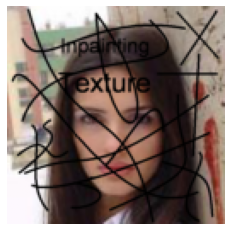

In [7]:
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

# img_clean_var = val_image.view(1, 3, image_size, image_size).to(device)
# img_noisy_var = Variable(img_clean_var).to(device) * mask_var
imgshow(img_noisy_var)
plt.axis('off')

In [7]:
# naive deep-decoder 4
rnd = 500
numit = 10000
rn = 0.005
num_channels = [64]*3

train_decoder = deconv_decoder(num_channels_up=num_channels, upsample_mode='none', filter_size=4, padding=[65]*4).type(dtype)

mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0015,
                        img_noisy_var=img_noisy_var,
                        net=train_decoder,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        upsample_mode='none'
                        )

final_output = net( ni.type(dtype) ).detach()

input shape:  [1, 64, 128, 128]
optimize with adam 0.0015


(-0.5, 127.5, 127.5, -0.5)

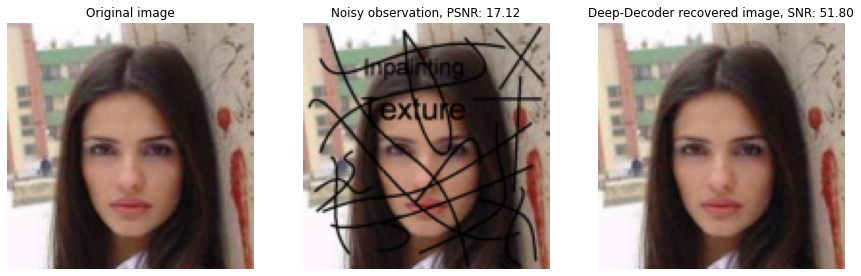

In [8]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

In [7]:
code_dim = 128 # 128 * 128
k = 64 # number of channels
Z = np.random.normal(size=(len(train_set), k, code_dim, code_dim)).astype(np.float32) # (number of low shots, 128)
Z = torch.tensor(Z, requires_grad=True).to(device) # Z[[0]].shape = [1, 64, 128, 128]

In [8]:
LV = LatentVariables(Z).to(device)

num_channels = [k]*3
p_net = deconv_decoder(num_channels_up=num_channels, upsample_mode='none', filter_size=4, padding=[65]*4).type(dtype)

g = CombinedModel(LV, p_net).to(device)
g.apply(weight_init)
print(num_param(g))
print(g)

8651456
CombinedModel(
  (Z): LatentVariables()
  (Decoder): Sequential(
    (1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(65, 65), bias=False)
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Sequential(
      (0): ReflectionPad2d((0, 0, 0, 0))
      (1): Conv2d(64, 3, kernel_size=(1, 1), stri

In [9]:
# prepare for pre-train
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(g.parameters(), lr=learning_rate)

Xi_train, _, _ = (next(iter(train_loader)))
train_number = np.arange(0, len(train_set))
train_number

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
# pre-train
epoch_pre = 1100
g, Z = pre_train(epoch_pre, 
                 train_loader, 
                 g, 
                 Z,
                 train_number,
                 optimizer, 
                 p_net,
                  "./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt")

In [8]:
# visual exam
final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
final_z_dict = torch.zeros((len(val_set), 64, 128, 128)).to(device)

psnr_list = np.zeros(len(val_set))

code_dim = 128
epoch_for_train_z = 2000
epoch_for_joint_train = 1000

num_channels = [64]*3

# load pre-trained decoder
train_decoder = deconv_decoder(num_channels_up=num_channels, upsample_mode='none', filter_size=4, padding=[65]*4).type(dtype)

if os.path.isfile("./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt"):
    print("loading...")
    train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt"))
    Z = torch.load("./low_shots_celeb/checkpoint/Z.pt")
else:
    train_decoder.apply(weight_init)

# initial z
target_z = np.reshape(np.mean(Z.data.cpu().numpy(), axis=0), (1, 64, 128, 128))
target_z = torch.tensor(target_z, requires_grad=True).to(device)

LV = LatentVariables(target_z).to(device)
train_g = CombinedModel(LV, train_decoder).to(device)

# train phase: train z to find z_hat
target_z_hat, _ = train(epoch_for_train_z, 
                        img_noisy_var, 
                        train_g, 
                        train_decoder, 
                        target_z, 
                        joint_train=False,
                        learning_rate=5 * 1e-4,
                        save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                        mask=mask_var,
                        measure=None)

loading...


In [9]:
for p in train_decoder.parameters():
    p.requires_grad = True

In [ ]:
# deep-decoder 4
rnd = 500
numit = 10000
rn = 0.005
num_channels = [64]*3
mse_n, mse_t, ni, net = new_fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0015,
                        img_noisy_var=img_noisy_var,
                        net=train_decoder,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        net_input = target_z_hat.data,
                        find_best=True,
                        upsample_mode='none'
                        )

final_output = net( ni.type(dtype) ).detach()

input provided
optimize with adam 0.0015


In [ ]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.cpu().numpy()[0].transpose(1, 2, 0), 0, 1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
myimgshow(ax1, img_clean_var) 
ax1.set_title('Original image')
ax1.axis('off')


ax2 = fig.add_subplot(132)
myimgshow(ax2, img_noisy_var)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_var.cpu().numpy(), img_noisy_var.cpu().numpy()) )
ax2.axis('off')

out_img_var = net( ni.type(dtype) ).detach()
ax3 = fig.add_subplot(133)
myimgshow(ax3, out_img_var)
ax3.set_title( "Deep-Decoder recovered image, SNR: %.2f" % psnr(img_clean_var.data.cpu().numpy(), out_img_var.data.cpu().numpy()[0]) ) 
ax3.axis('off')

In [13]:
# visual results for inpainting task
def myimgshow(plt, img):
    plt.imshow(np.clip(img.data.cpu().numpy().squeeze().transpose(1, 2, 0), 0, 1))

def plot_all(plt, i):
    Xi_val, _ = val_set[i]
    Xi_val = Xi_val.to(device)
    
    fig = plt.figure(figsize = (15,15)) 
    
    ax1 = fig.add_subplot(131)
    myimgshow(ax1, Xi_val)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(132)
    myimgshow(ax2, Xi_val * mask_var)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), (Xi_val.cpu().numpy() * mask_var.cpu().numpy())))
    ax2.axis('off')

    ax3 = fig.add_subplot(133)
    myimgshow(ax3, final_output[idx])
    ax3.set_title( "Recovered image, PSNR: %.2f" % psnr(Xi_val.cpu().numpy(), final_output[idx].detach().cpu().numpy()) ) 
    ax3.axis('off') 

NameError: name 'final_output' is not defined

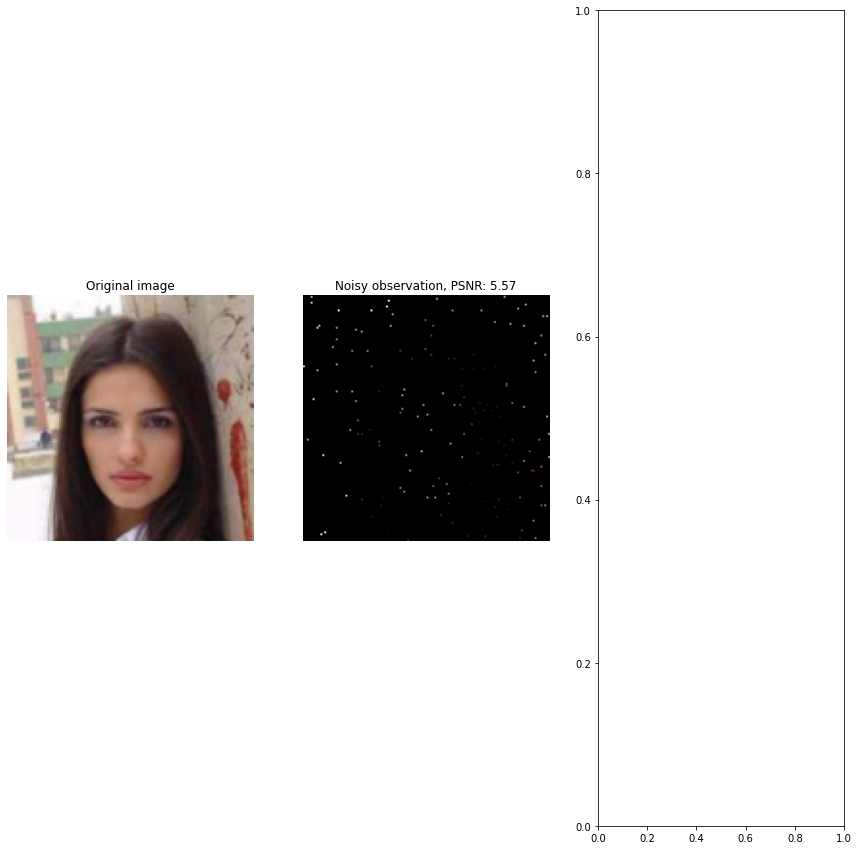

In [14]:
for i in range(1, 5):
    plot_all(plt, i)

In [ ]:
for i in range(1, 5):
    plot_all(plt, i)

In [ ]:
# visual exam
final_output = torch.zeros((len(val_set), 3, 128, 128)).to(device)
final_z_dict = torch.zeros((len(val_set), 64, 128, 128)).to(device)

psnr_list = np.zeros(len(val_set))

code_dim = 128
epoch_for_train_z = 2000
epoch_for_joint_train = 1000

mask = masks[5].to(device)

for i, (Xi_val, _, idx_val) in enumerate(val_loader):
    progress = tqdm(total=1, desc='loop % 3d' % i)
    # for image i
    Xi_val = Variable(Xi_val).to(device)
    Xi_val_noisy = (Xi_val * mask).to(device)

    # load pre-trained decoder
    train_decoder = deconv_decoder(num_channels_up=num_channels, upsample_mode='none', filter_size=4, padding=[65]*4).type(dtype)
    
    if os.path.isfile("./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt"):
        train_decoder.load_state_dict(torch.load("./low_shots_celeb/checkpoint/p_deepdecoder4_4shots.pt"))
        Z = torch.load("./low_shots_celeb/checkpoint/Z.pt")
    else:
        train_decoder.apply(weight_init)

    # initial z
    target_z = np.reshape(np.mean(Z.data.cpu().numpy(), axis=0), (1, 64, 128, 128))
    target_z = torch.tensor(target_z, requires_grad=True).to(device)

    # combined model train_g
    LV_target_z = LatentVariables(target_z).to(device)
    train_g = CombinedModel(LV_target_z, train_decoder).to(device)

    # train phase: train z to find z_hat
    target_z_hat, _ = train(epoch_for_train_z, 
                            Xi_val_noisy, 
                            train_g, 
                            train_decoder, 
                            target_z, 
                            joint_train=False,
                            learning_rate=5 * 1e-4,
                            save_path="./low_shots_celeb/checkpoint/current_checkpoint_train_z.pt",
                            mask=mask,
                            measure=None)

    # train phase: joint train
    warm_start_z = LatentVariables(target_z_hat).to(device)
    joint_train_g = CombinedModel(warm_start_z, train_decoder).to(device)

    final_z, final_G = train(epoch_for_joint_train, 
                         Xi_val_noisy, 
                         joint_train_g,
                         train_decoder, 
                         target_z_hat, 
                         joint_train=True,
                         learning_rate=1e-4,
                         save_path="./low_shots_celeb/checkpoint/current_checkpoint_final.pt",
                         mask=mask,
                         measure=None)

    final_output[i] = final_G
    final_z_dict[i] = final_z
    psnr_list[i] = psnr(Xi_val.cpu().numpy(), final_G.detach().cpu().numpy())

    progress.set_postfix({'loss': loss_fn(final_G * mask, Xi_val* mask).item()})
    progress.update()
    if i == 6:
        break